<a href="https://colab.research.google.com/github/nmhaaa3218/CV-Facial-Expression/blob/main/Facial_Expression_Recognition_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Expression Recognition Competition (30%)**
For this competition, we will use the a facial classification dataset. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

We provide baseline code that includes the following features:

*   Loding and Analysing the FER-2013 dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following changes could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]


In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Manh Ha Nguyen, Le Thuy An Phan
### Student ID: a1840406, a1874923
### Comptetion Name: Facial Expression Recognition/Classification
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

# Set Up

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!pip install fvcore

In [84]:
# Importing libraries.

import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [85]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
data_directory ='/content/drive/MyDrive/Datasets/fer2013/fer2013.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Reading the dataset file using Pandas read_csv function and print the first
# 5 samples.
#
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
data_df = pd.read_csv(data_directory)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [87]:
# Mapping of the Facial Expression Labels.
Labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [88]:
# Categorizing the dataset to three categories.
# Training: To train the model.
# PrivateTest: To test the train model; commonly known as Validation.
# PublicTest: To test the final model on Test set to check how your model perfomed. Do not use this data as your validation data.
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PublicTest']
test_df = data_df[data_df['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [89]:
# Test-check to see wether usage labels have been allocated to the dataset/not.
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [90]:
# Preview of the training sample and associated labels.
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


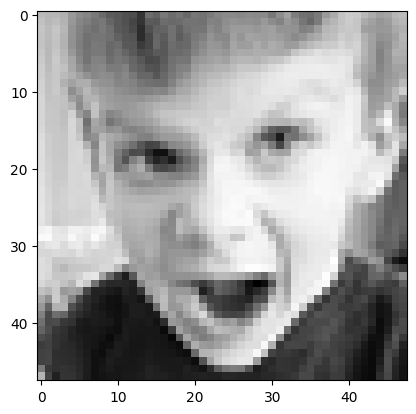

In [91]:
show_example(train_df, 107)

In [92]:
# Normalization of the train and validation data.
class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))


        if self.transforms:
            image = self.transforms(image)

        return image.clone().detach(), label

In [93]:
#import albumentations as A
stats = ([0.5],[0.5])

In [94]:
train_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True),
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)
])

In [95]:
train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)

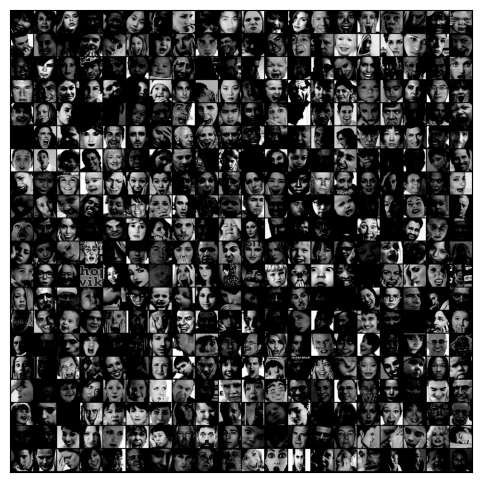

In [96]:
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

show_batch(train_dl)

In [97]:
# Evaluation metric - Accuracy in this case.

import torch.nn.functional as F
input_size = 48*48
output_size = len(Labels)

def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [98]:
# Expression model class for training and validation purpose.

class expression_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [99]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(f'You are training on: {device}.')

You are training on: cuda.


In [100]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [101]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [102]:
# Functions for evaluation and training.
@torch.no_grad()
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [103]:
# Plots for accuracy and loss during training period.
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [104]:
# Prediction function to evaluate the model.
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

In [105]:
# Count number of parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Xavier weight initialization
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)


# Baseline Models

In [106]:
# Basic model - 1 layer
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [107]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([400, 1, 48, 48])
out.shape: torch.Size([400, 8, 24, 24])


In [108]:
# Model - 7 layer
class expression(expression_model):
    def __init__(self,classes):
        super().__init__()
        self.num_classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(),
            nn.Linear(256*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576,288),
            nn.ReLU(),
            nn.Linear(288,144),
            nn.ReLU(),
            nn.Linear(144,self.num_classes))

    def forward(self, xb):
        return self.network(xb)

In [109]:
# Model print
model = to_device(expression(classes = 7), device)
model

expression(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_

In [110]:
evaluate(model, valid_dl)

{'val_loss': 1.958022952079773, 'val_acc': 0.11484382301568985}

In [111]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [112]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch[0], val_loss: 1.8118, val_acc: 0.2486
Epoch[1], val_loss: 1.7933, val_acc: 0.2486
Epoch[2], val_loss: 1.7518, val_acc: 0.2794
Epoch[3], val_loss: 1.6473, val_acc: 0.3511
Epoch[4], val_loss: 1.6037, val_acc: 0.3620
Epoch[5], val_loss: 1.4802, val_acc: 0.4151
Epoch[6], val_loss: 1.3973, val_acc: 0.4476
Epoch[7], val_loss: 1.3843, val_acc: 0.4576
Epoch[8], val_loss: 1.3021, val_acc: 0.4866
Epoch[9], val_loss: 1.3048, val_acc: 0.4841


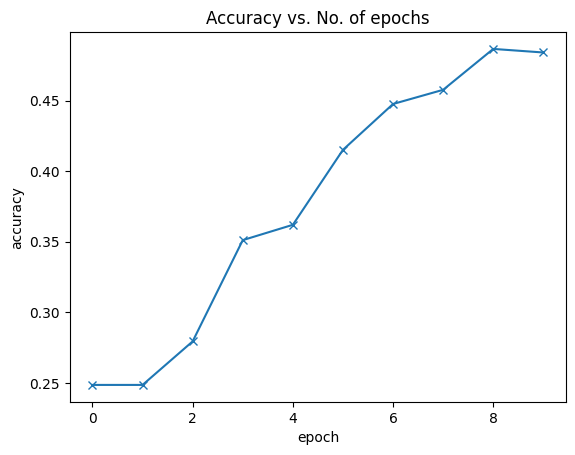

In [113]:
plot_accuracies(history)

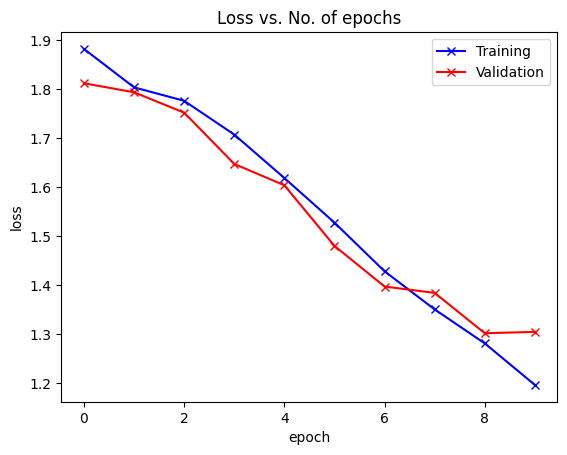

In [114]:
plot_losses(history)

In [115]:
# Model evaluation on test data.
result = evaluate(model, test_dl)
result

{'val_loss': 1.2849340438842773, 'val_acc': 0.4967525601387024}

Label: Angry , Predicted: Angry


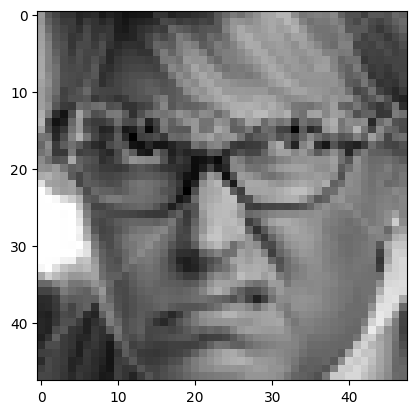

In [116]:
img, label = test_ds[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

Label: Angry , Predicted: Fear


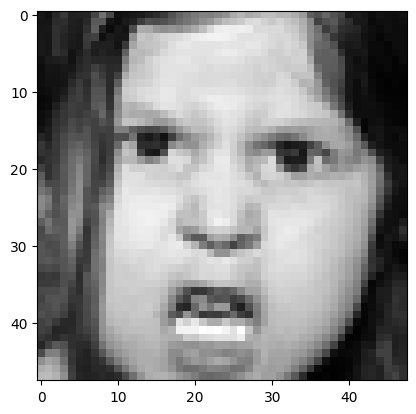

In [117]:
img, label = test_ds[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [118]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

In [119]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 7
model = expression(num_classes)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

FLOPs: 0.32751 GFLOPs


In [120]:
# Baseline efficiency
acc = result['val_acc']
efficiency = acc / (flops.total()/1e9)
print(f"Baseline Efficiency: {efficiency}")

Baseline Efficiency: 1.5167767379497141


# Experiment with ResEmoteNet

In [ ]:
# ——— SE and Residual blocks ———
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # if shape changes, match it with a 1×1 conv
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        return F.relu(out)


# ——— Integrated model ———
class ResExpressionModel(expression_model):
    def __init__(self, num_classes, in_channels=1):
        super().__init__()
        # initial conv layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(256)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        # squeeze‐and‐excitation
        self.se = SEBlock(256)

        # residual layers
        self.res1 = ResidualBlock(256, 512, stride=2)
        self.res2 = ResidualBlock(512, 1024, stride=2)
        self.res3 = ResidualBlock(1024, 2048, stride=2)

        # classifier head
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Stem
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # SE
        x = self.se(x)

        # Residual stacks
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        # Head
        x = self.global_pool(x)              # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)            # [B, 2048]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [ ]:
model_ren = to_device(ResExpressionModel(num_classes = 7, in_channels=1), device)
model_ren.apply(init_weights)
print(count_params(model_ren))
print(model_ren)

In [ ]:
num_epochs = 80
lr = 0.001
patience = 15

best_val_acc = 0.0
epochs_no_improve = 0

history_ren = []
optimizer = torch.optim.SGD(model_ren.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

for epoch in range(num_epochs):
    # Training Phase
    model_ren.train()
    train_losses = []
    for batch in train_dl:
        loss = model_ren.training_step(batch)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = evaluate(model_ren, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_ren.epoch_end(epoch, result)
    history_ren.append(result)

    # Early-stopping + checkpointing
    val_acc = result['val_acc']
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # save current best model
        torch.save(model_ren.state_dict(), 'model_ren.pth')
        print(f"→ New best val_acc={val_acc:.4f}, checkpoint saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (no val_acc improvement for {patience} epochs).")
            break


In [ ]:
plot_accuracies(history_ren)


In [ ]:
plot_losses(history_ren)

In [ ]:
from fvcore.nn import FlopCountAnalysis

result_ren = evaluate(model_ren, test_dl)
print("Test result:", result_ren)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops = FlopCountAnalysis(model_ren.eval(), dummy_input)
gflops = flops.total() / 1e9
acc = result_ren['val_acc']
efficiency = acc / gflops
print(f"ResEmoteNet GFLOPs: {gflops}")
print(f"ResEmoteNet Accuracy: {acc}")
print(f"ResEmoteNet Efficiency: {efficiency}")

# Vision Transformer

In [ ]:
class VisionTransformer(expression_model):
    def __init__(self,
                 img_size: int = 48,
                 patch_size: int = 6,
                 in_chans: int = 1,
                 num_classes: int = 7,
                 embed_dim: int = 256,
                 depth: int = 6,
                 num_heads: int = 8,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1):
        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size"
        num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_chans, embed_dim,
                                     kernel_size=patch_size,
                                     stride=patch_size)
        # class token + positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        # build Transformer encoder
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_hidden_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # initialize
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: [B, 1, 48, 48]
        B = x.size(0)
        # patch embedding -> [B, E, P, P]  where P=img_size/patch_size
        x = self.patch_embed(x)
        # flatten patches
        x = x.flatten(2).transpose(1, 2)  # -> [B, num_patches, E]

        # prepend cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, E]
        x = torch.cat((cls_tokens, x), dim=1)          # [B, 1+num_patches, E]
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Transformer
        x = self.encoder(x)            # [B, 1+num_patches, E]
        x = self.norm(x)
        cls_out = x[:, 0]              # take cls token
        return self.head(cls_out)      # [B, num_classes]




In [ ]:
# 3) Instantiate, move to device, and train just like your other models
model_vit = VisionTransformer(
        img_size=48, patch_size=6,
        in_chans=1, num_classes=7,
        embed_dim=256, depth=6,
        num_heads=8, mlp_ratio=2.0, dropout=0.15
    )
model_vit = to_device(model_vit, device)
print(count_params(model_vit))
print(model_vit)



In [ ]:
# ────────── ViT-48: config ─────────────────────────────────────────────────
num_epochs_vit   = 100
patience_vit     = 20
base_lr_vit      = 3e-4
max_lr_vit       = 5e-3

best_val_acc_vit = 0.0
epochs_no_imp_vit = 0
history_vit      = []

model_vit = to_device(
    VisionTransformer(
        img_size=48, patch_size=6,
        in_chans=1, num_classes=7,
        embed_dim=256, depth=6,
        num_heads=8, mlp_ratio=2.0, dropout=0.15
    ),
    device
)

# ─── split params (decay / no-decay) ────────────────────────────────────────
decay, no_decay = [], []
for n, p in model_vit.named_parameters():
    if not p.requires_grad:      continue
    (no_decay if p.dim()==1 or n.endswith(".bias") else decay).append(p)

optimizer_vit = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': 0.05},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_vit, betas=(0.9, 0.9995)
)

scheduler_vit = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_vit,
    max_lr          = max_lr_vit,
    steps_per_epoch = len(train_dl),
    epochs          = num_epochs_vit,
    pct_start       = 0.05
)

# ────────── training / validation loop ─────────────────────────────────────
for epoch in range(num_epochs_vit):
    model_vit.train()
    train_losses = []

    for batch in train_dl:
        loss = model_vit.training_step(batch)
        train_losses.append(loss.detach())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vit.parameters(), 1.0)
        optimizer_vit.step();  optimizer_vit.zero_grad()
        scheduler_vit.step()

    result = evaluate(model_vit, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_vit.epoch_end(epoch, result)
    history_vit.append(result)

    # ─── early-stopping / checkpoint ───────────────────────────────────────
    val_acc = result['val_acc']
    if val_acc > best_val_acc_vit:
        best_val_acc_vit, epochs_no_imp_vit = val_acc, 0
        torch.save(model_vit.state_dict(), 'model_vit_best.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_vit += 1
        if epochs_no_imp_vit >= patience_vit:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_vit} epochs).")
            break

# ────────── final test ─────────────────────────────────────────────────────
model_vit.load_state_dict(torch.load('model_vit_best.pth'))
test_metrics_vit = evaluate(model_vit, test_dl)
print(f"★ ViT-48 test accuracy: {test_metrics_vit['val_acc']:.4f}")


In [ ]:
# 5) Plot its curves
plot_accuracies(history_vit)



In [ ]:
plot_losses(history_vit)

In [ ]:
# 6) Final evaluation on the test set
result_vit = evaluate(model_vit, test_dl)
print("Test result:", result_vit)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops = FlopCountAnalysis(model_vit.eval(), dummy_input)
gflops = flops.total() / 1e9
acc = result_vit['val_acc']
efficiency = acc / gflops
print(f"ViT GFLOPs: {gflops}")
print(f"ViT Accuracy: {acc}")
print(f"ViT Efficiency: {efficiency}")

# VGG 19 (modified)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) Configuration for VGG-19 with BatchNorm
_cfg_vgg19_bn = [
    64, 64, 'M',
    128, 128, 'M',
    256, 256, 256, 256, 'M',
    512, 512, 512, 512, 'M',
    512, 512, 512, 512, 'M',
]

def make_layers(cfg, in_channels=1):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [
                nn.Conv2d(in_channels, v, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(v),
                nn.ReLU(inplace=True)
            ]
            in_channels = v
    return nn.Sequential(*layers)

# 2) VGG-19 model
class VGG19ExpressionModel(expression_model):
    def __init__(self, num_classes=7, in_channels=1):
        super().__init__()
        # feature extractor (5 × conv-blocks + pool)
        self.features = make_layers(_cfg_vgg19_bn, in_channels)
        # reduce whatever spatial size remains to 1×1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # classifier head (512→4096→4096→num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)           # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 512]
        x = self.classifier(x)        # [B, num_classes]
        return x

# 3) Instantiate and sanity-check
model_vgg = to_device(VGG19ExpressionModel(num_classes=7, in_channels=1), device)
model_vgg.apply(init_weights)
print(model_vgg)
print(f"Total params: {count_params(model_vgg)}")


In [ ]:
# ────────── config ─────────────────────────────────────────────────────────────
num_epochs   = 80
patience     = 15
base_lr      = 3e-4          # ← changed
max_lr       = 1e-3          # peak for One-Cycle

best_val_acc = 0.0
epochs_no_improve = 0
history_vgg  = []

# ─── split parameters to skip weight-decay on bias & norm ─────────────────────
decay, no_decay = [], []
for name, p in model_vgg.named_parameters():
    if not p.requires_grad:
        continue
    if p.dim() == 1 or name.endswith(".bias"):   # BN/LayerNorm or bias
        no_decay.append(p)
    else:
        decay.append(p)

optimizer = torch.optim.AdamW(
    [{'params': decay,     'weight_decay': 1e-4},
     {'params': no_decay,  'weight_decay': 0.0}],
    lr = base_lr,
    betas = (0.9, 0.9995)
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = max_lr,
    steps_per_epoch = len(train_dl),
    epochs = num_epochs,
    pct_start = 0.1,   # 10 % warm-up
)

# ────────── training/validation ───────────────────────────────────────────────
for epoch in range(num_epochs):
    model_vgg.train()
    train_losses = []

    for batch in train_dl:
        loss = model_vgg.training_step(batch)
        train_losses.append(loss.detach())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vgg.parameters(), 1.0)  # optional clip
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

    result = evaluate(model_vgg, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_vgg.epoch_end(epoch, result)
    history_vgg.append(result)

    # ─── early-stopping / checkpoint ──────────────────────────────────────────
    val_acc = result['val_acc']
    if val_acc > best_val_acc:
        best_val_acc, epochs_no_improve = val_acc, 0
        torch.save(model_vgg.state_dict(), 'model_vgg_best.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience} epochs).")
            break




In [ ]:
plot_accuracies(history_vgg)

In [ ]:
plot_losses(history_vgg)

In [ ]:
from fvcore.nn import FlopCountAnalysis
# ────────── final test ────────────────────────────────────────────────────────
model_vgg.load_state_dict(torch.load('model_vgg_best.pth'))

# 6) Final evaluation on the test set
result_vgg = evaluate(model_vgg, test_dl)
print("Test result:", result_vgg)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops = FlopCountAnalysis(model_vgg.eval(), dummy_input)
gflops = flops.total() / 1e9
acc = result_vgg['val_acc']
efficiency = acc / gflops
print(f"VGG GFLOPs: {gflops}")
print(f"VGG Accuracy: {acc}")
print(f"VGG Efficiency: {efficiency}")